# Plots for TTN project with HIGGS dataset

***

<br>
<br>
<br>
<br>
<br>

***

## Preliminary operations

### Load packages

In [1]:
import os
import sys
import pandas as pd
import json
import time
import os
import math
import tensorflow        as tf
import tensornetwork     as tn
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import datetime
import itertools

from tensorflow.keras.models      import Sequential
from tensorflow.keras             import regularizers
from tensorflow.keras.models      import load_model

sys.path.insert(0, "../src") 
import utils.preprocess as preprocess
from layers.TTN_SingleNode        import TTN_SingleNode

from sklearn.preprocessing        import MinMaxScaler
from sklearn.metrics              import roc_auc_score
from sklearn.metrics              import confusion_matrix
from sklearn.metrics              import roc_curve

### Settings

#### Plot font sizes

In [2]:
plt.rc('text',   usetex   =True)
plt.rc('font',   family   ='serif')
plt.rc('font',   size     =16)     # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=12)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=12)     # fontsize of the tick labels
plt.rc('legend', fontsize =16)     # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

In [3]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath',r'\usepackage{slashed}',r'\usepackage{physics}']

#### Plot styles

In [4]:
# number of bins
NBINS   = 100

# kwargs
LW_BKG  = 2         # linewidth
LW_SIG  = 2         # linewidth
EC_BKG  = "C0"      # edgecolor
EC_SIG  = "C1"      # edgecolor
HTYPE   = "step"    # histtype

# density
DENSITY = True

### Paths

In [5]:
USER_PATH = os.getcwd()
DATA_PATH = USER_PATH + "/../data/"
SAVE_PATH = USER_PATH + "/images/"
JSON_PATH = USER_PATH + "/../json/"

### Constants

#### Flags

In [6]:
PLOT_DATA = True

#### Number of events to take

In [7]:
N = 11000000

#### Feature strings and index

In [8]:
# lepton pT, lepton eta, lepton phi
# missing energy magnitude, missing energy phi
# jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag
# jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag
# jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag
# jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag
# m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb
features = {
    # label
    "label"      :  0,
    # low-level features
    "l_pt"       : {"index" :  1, "range" : [ 0.0, 5.0], "title" : r"\bf{Lepton $p_{\mathrm{T}}$}",                "xlabel" : r"\bf{$p_{\mathrm{T}}$}", "ylabel" : r"\bf{Density}"},
    "l_eta"      : {"index" :  2, "range" : [-3.0, 3.0], "title" : r"\bf{Lepton $\eta$}",                          "xlabel" : r"\bf{$\eta$}",           "ylabel" : r"\bf{Density}"},
    "l_phi"      : {"index" :  3, "range" : [-3.0, 3.0], "title" : r"\bf{Lepton $\phi$}",                          "xlabel" : r"\bf{$\phi$}",           "ylabel" : r"\bf{Density}"},
    "miss_E_mag" : {"index" :  4, "range" : [ 0.0, 5.0], "title" : r"\bf{Missing energy magnitude $\slashed{E}$}", "xlabel" : r"\bf{$\slashed{E}$}",    "ylabel" : r"\bf{Density}"},
    "miss_E_phi" : {"index" :  5, "range" : [-3.0, 3.0], "title" : r"\bf{Missing energy $\slashed{\phi}$}",        "xlabel" : r"\bf{$\slashed{\phi}$}", "ylabel" : r"\bf{Density}"},
    "j1_pt"      : {"index" :  6, "range" : [ 0.0, 5.0], "title" : r"\bf{Jet 1 $p_{\mathrm{T}}$}",                 "xlabel" : r"\bf{$p_{\mathrm{T}}$}", "ylabel" : r"\bf{Density}"},
    "j1_eta"     : {"index" :  7, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 1 $\eta$}",                           "xlabel" : r"\bf{$\eta$}",           "ylabel" : r"\bf{Density}"},
    "j1_phi"     : {"index" :  8, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 1 $\phi$}",                           "xlabel" : r"\bf{$\phi$}",           "ylabel" : r"\bf{Density}"},
    "j1_btag"    : {"index" :  9, "range" : [ 0.0, 4.0], "title" : r"\bf{Jet 1 $b$-tag}",                          "xlabel" : r"\bf{$b$-tag}",          "ylabel" : r"\bf{Density}"},
    "j2_pt"      : {"index" : 10, "range" : [ 0.0, 5.0], "title" : r"\bf{Jet 2 $p_{\mathrm{T}}$}",                 "xlabel" : r"\bf{$p_{\mathrm{T}}$}", "ylabel" : r"\bf{Density}"},
    "j2_eta"     : {"index" : 11, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 2 $\eta$}",                           "xlabel" : r"\bf{$\eta$}",           "ylabel" : r"\bf{Density}"},
    "j2_phi"     : {"index" : 12, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 2 $\phi$}",                           "xlabel" : r"\bf{$\phi$}",           "ylabel" : r"\bf{Density}"},
    "j2_btag"    : {"index" : 13, "range" : [ 0.0, 4.0], "title" : r"\bf{Jet 2 $b$-tag}",                          "xlabel" : r"\bf{$b$-tag}",          "ylabel" : r"\bf{Density}"},
    "j3_pt"      : {"index" : 14, "range" : [ 0.0, 5.0], "title" : r"\bf{Jet 3 $p_{\mathrm{T}}$}",                 "xlabel" : r"\bf{$p_{\mathrm{T}}$}", "ylabel" : r"\bf{Density}"},
    "j3_eta"     : {"index" : 15, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 3 $\eta$}",                           "xlabel" : r"\bf{$\eta$}",           "ylabel" : r"\bf{Density}"},
    "j3_phi"     : {"index" : 16, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 3 $\phi$}",                           "xlabel" : r"\bf{$\phi$}",           "ylabel" : r"\bf{Density}"},
    "j3_btag"    : {"index" : 17, "range" : [ 0.0, 4.0], "title" : r"\bf{Jet 3 $b$-tag}",                          "xlabel" : r"\bf{$b$-tag}",          "ylabel" : r"\bf{Density}"},
    "j4_pt"      : {"index" : 18, "range" : [ 0.0, 5.0], "title" : r"\bf{Jet 4 $p_{\mathrm{T}}$}",                 "xlabel" : r"\bf{$p_{\mathrm{T}}$}", "ylabel" : r"\bf{Density}"},
    "j4_eta"     : {"index" : 19, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 4 $\eta$}",                           "xlabel" : r"\bf{$\eta$}",           "ylabel" : r"\bf{Density}"},
    "j4_phi"     : {"index" : 20, "range" : [-3.0, 3.0], "title" : r"\bf{Jet 4 $\phi$}",                           "xlabel" : r"\bf{$\phi$}",           "ylabel" : r"\bf{Density}"},
    "j4_btag"    : {"index" : 21, "range" : [ 0.0, 4.0], "title" : r"\bf{Jet 4 $b$-tag}",                          "xlabel" : r"\bf{$b$-tag}",          "ylabel" : r"\bf{Density}"},
    # high-level features
    "m_jj"       : {"index" : 22, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{jj}$}",                "xlabel" : r"\bf{$m_{jj}$}",         "ylabel" : r"\bf{Density}"},
    "m_jjj"      : {"index" : 23, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{jjj}$}",               "xlabel" : r"\bf{$m_{jjj}$}",        "ylabel" : r"\bf{Density}"},
    "m_lv"       : {"index" : 24, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{\ell\nu}$}",           "xlabel" : r"\bf{$m_{\ell\nu}$}",    "ylabel" : r"\bf{Density}"},
    "m_jlv"      : {"index" : 25, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{j\ell\nu}$}",          "xlabel" : r"\bf{$m_{j\ell\nu}$}",   "ylabel" : r"\bf{Density}"},
    "m_bb"       : {"index" : 26, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{bb}$}",                "xlabel" : r"\bf{$m_{bb}$}",         "ylabel" : r"\bf{Density}"},
    "m_wbb"      : {"index" : 27, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{Wbb}$}",               "xlabel" : r"\bf{$m_{Wbb}$}",        "ylabel" : r"\bf{Density}"},
    "m_wwbb"     : {"index" : 28, "range" : [ 0.0, 3.0], "title" : r"\bf{Invariant mass $m_{WWbb}$}",              "xlabel" : r"\bf{$m_{WWbb}$}",       "ylabel" : r"\bf{Density}"}
}

***

<br>
<br>
<br>
<br>
<br>

***

## Load dataset

In [9]:
if PLOT_DATA:
    if os.path.isfile(DATA_PATH + "HIGGS.csv.gz"):
        df = pd.read_csv(DATA_PATH + "HIGGS.csv.gz", nrows=N, compression='gzip', error_bad_lines=False, header=None)
    elif os.path.isfile(DATA_PATH + "HIGGS.csv"):
        df = pd.read_csv(DATA_PATH + "HIGGS.csv",    nrows=N,                     error_bad_lines=False, header=None)
    
    df_bkg = df[df[0]==0]
    df_sig = df[df[0]==1]
    
    print("BKG data shape:", df_bkg.shape)
    print("SIG data shape:", df_sig.shape)
    
    del df

BKG data shape: (5170877, 29)
SIG data shape: (5829123, 29)


***

<br>
<br>
<br>
<br>
<br>

***

## Features plot

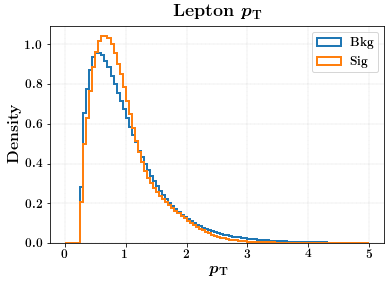

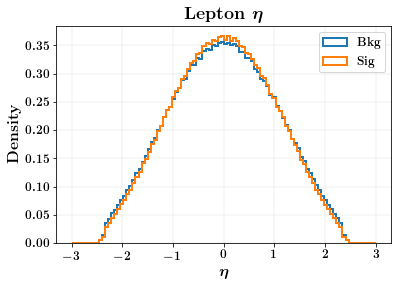

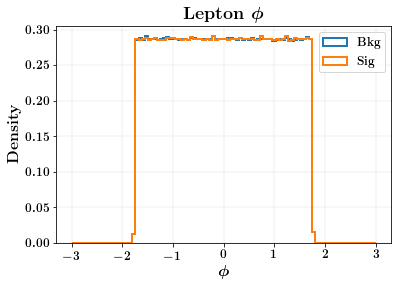

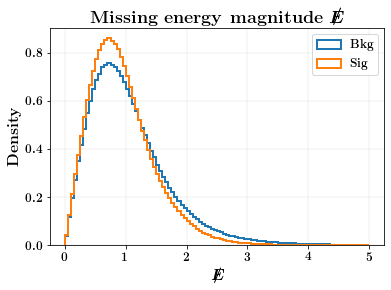

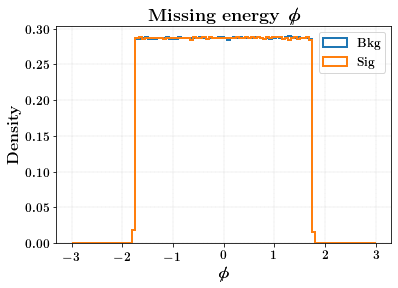

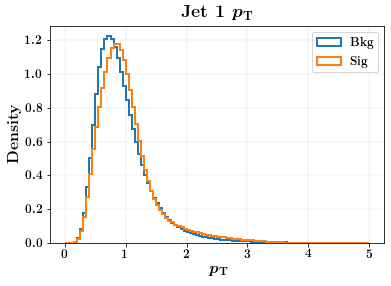

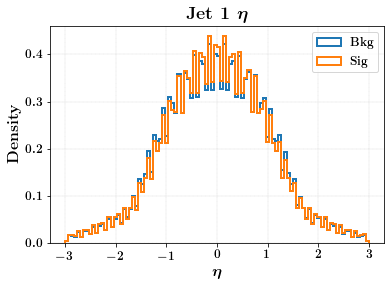

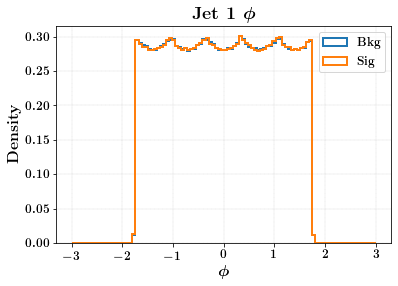

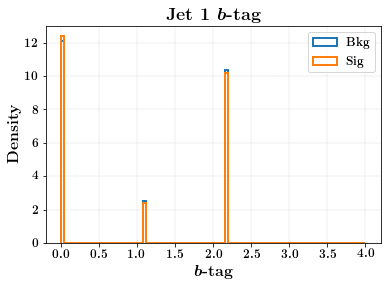

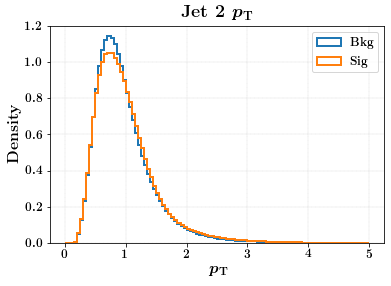

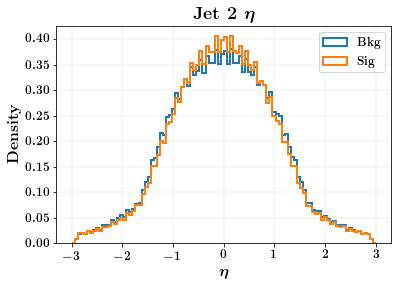

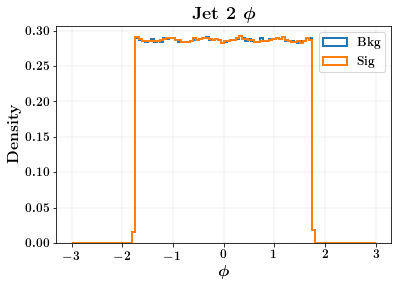

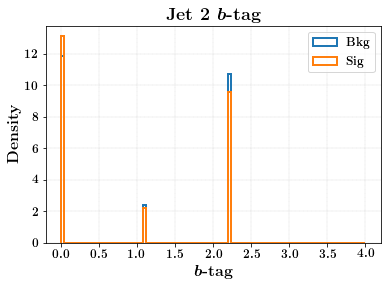

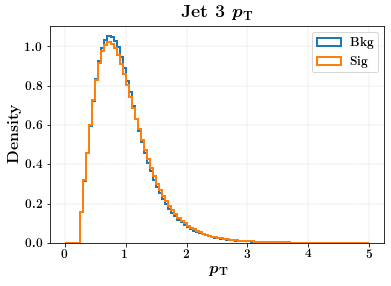

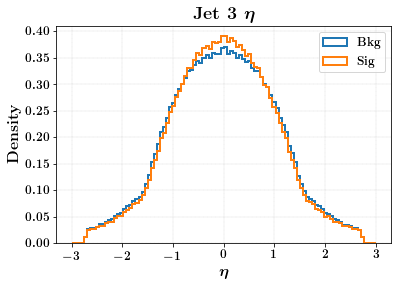

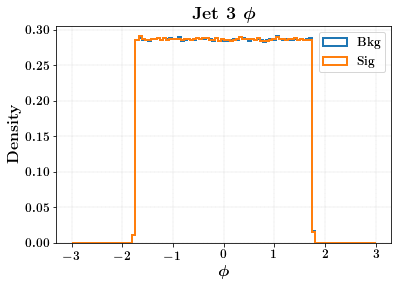

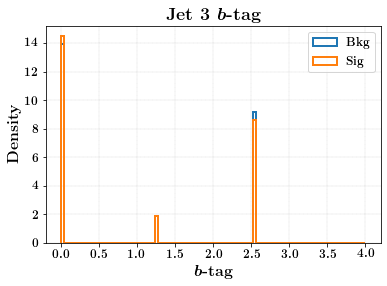

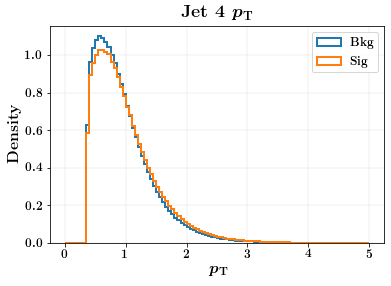

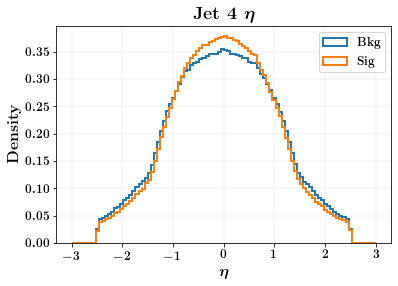

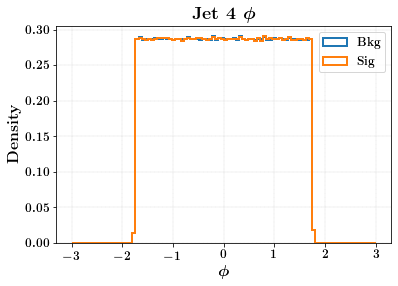

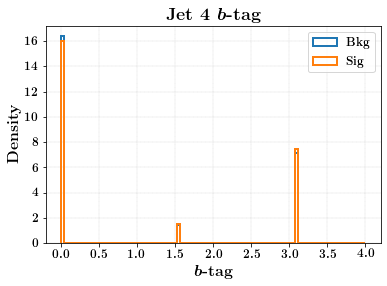

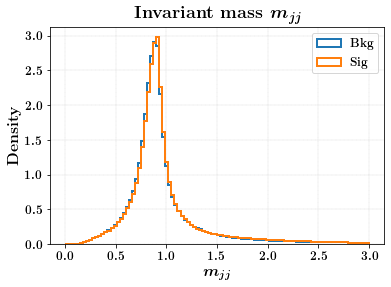

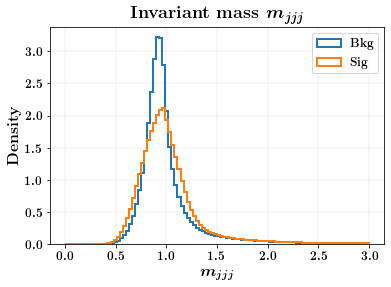

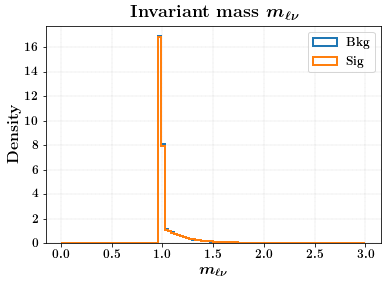

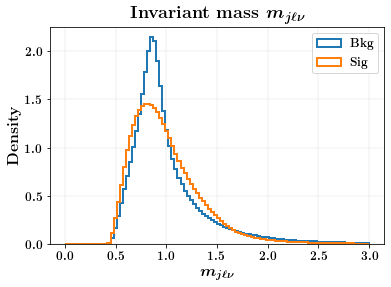

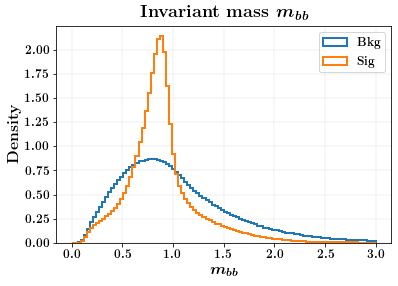

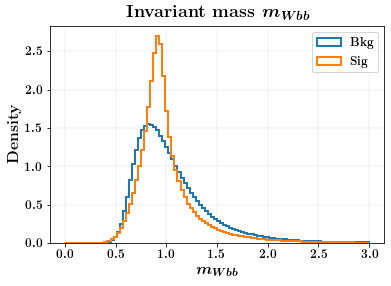

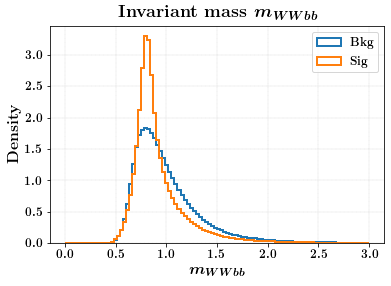

In [10]:
if PLOT_DATA:
    for i, FEATURE in enumerate(features.keys()):
        if i==0:
            continue

        plt.figure(figsize=(6,4))
        plt.axes(axisbelow=True)

        plt.hist(
            x         = df_bkg[features[FEATURE]["index"]],
            linewidth = LW_BKG,
            edgecolor = EC_BKG,
            bins      = NBINS,
            histtype  = HTYPE,
            density   = DENSITY,
            range     = features[FEATURE]["range"],
            label     = r"\bf{Bkg}"
        )
        plt.hist(
            x         = df_sig[features[FEATURE]["index"]],
            linewidth = LW_SIG,
            edgecolor = EC_SIG,
            bins      = NBINS,
            histtype  = HTYPE,
            density   = DENSITY,
            range     = features[FEATURE]["range"],
            label     = r"\bf{Sig}"
        )
        plt.title(features[FEATURE]["title"])
        plt.xlabel(features[FEATURE]["xlabel"])
        plt.ylabel(features[FEATURE]["ylabel"])
        plt.legend(fontsize=12)
        plt.grid(linestyle='--', linewidth=0.25)
        plt.savefig(SAVE_PATH + "features/" + FEATURE + ".pdf", bbox_inches='tight')

        plt.show()
    
    del df_bkg
    del df_sig

***

<br>
<br>
<br>
<br>
<br>

***

## Activation functions plot

### Definition of activations and derivatives

#### ELU

In [11]:
def elu(x):
    if x > 0 :
        return x
    else : 
        return (np.exp(x)-1)

def der_elu(x):
    if x > 0 :
        return 1
    else :
        return np.exp(x)

#### Sigmoid

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def der_sigmoid(x):
    return 1/(1+np.exp(-x)) * (1-1/(1+np.exp(-x)))

#### Hyperbolic tangent

In [13]:
def hyperb(x):
    return (np.exp(x)-np.exp(-x)) / (np.exp(x) + np.exp(-x))

def der_hyperb(x):
    return 1 - ((np.exp(x)-np.exp(-x)) / (np.exp(x) + np.exp(-x)))**2

#### ReLU

In [14]:
def relu(x) :
    return max(x, 0)

def der_relu(x):
    if x <= 0 :
        return 0
    if x > 0 :
        return 1

#### Leaky ReLU

In [15]:
def leaky_relu(x):
    return max(0.01*x,x)

def der_leaky_relu(x):
    if x < 0 :
        return 0.01
    if x >= 0 :
        return 1

### Plot of activations

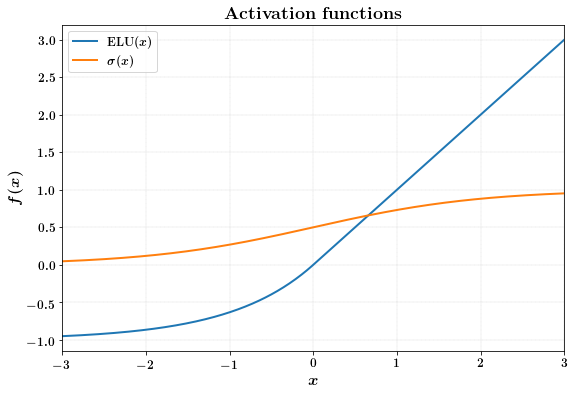

In [16]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

x = np.linspace(-3,3,500)
plt.plot(x, list(map(lambda x: elu(x),     x)), "-", label=r"\bf{$\mathrm{ELU}(x)$}", linewidth=2, markersize=5)
plt.plot(x, list(map(lambda x: sigmoid(x), x)), "-", label=r"\bf{$\sigma(x)$}",       linewidth=2, markersize=5)
# plt.plot(x, list(map(lambda x: hyperb(x),  x)), ".", label=r"\bf{tanh}"   , linewidth=2, markersize=5)
# plt.plot(x, list(map(lambda x: relu(x),    x)), ".", label=r"\bf{ReLU}"   , linewidth=2, markersize=5)

plt.xlim(-3,3)
plt.xlabel(r"\bf{$x$}")
plt.ylabel(r"\bf{$f(x)$}")
plt.title(r"\bf{Activation functions}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "activations/activations.pdf", bbox_inches='tight')
plt.show()

### Plot of activations derivatives

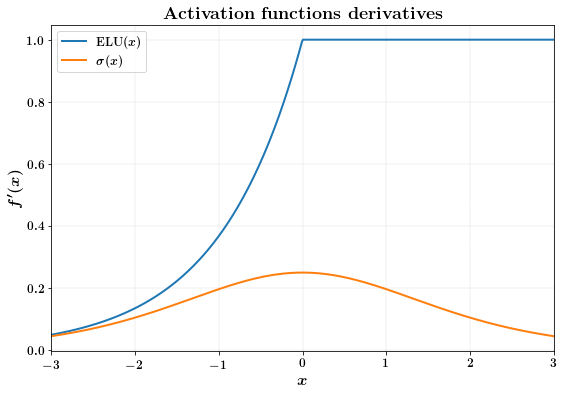

In [17]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

x = np.linspace(-3,3,500)
plt.plot(x, list(map(lambda x: der_elu(x),     x)), "-", label=r"\bf{$\mathrm{ELU}(x)$}", linewidth=2, markersize=5)
plt.plot(x, list(map(lambda x: der_sigmoid(x), x)), "-", label=r"\bf{$\sigma(x)$}",       linewidth=2, markersize=5)
# plt.plot(x, list(map(lambda x: der_hyperb(x),  x)), ".", label=r"\bf{tanh}"   , linewidth=2, markersize=5)
# plt.plot(x, list(map(lambda x: der_relu(x),    x)), ".", label=r"\bf{ReLU}"   , linewidth=2, markersize=5)

plt.xlim(-3,3)
plt.xlabel(r"\bf{$x$}")
plt.ylabel(r"\bf{$f^{\prime}(x)$}")
plt.title(r"\bf{Activation functions derivatives}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "activations/derivatives.pdf", bbox_inches='tight')
plt.show()

***

<br>
<br>
<br>
<br>
<br>

***

## Results: pure and advanced TTNs comparison

### Load data

In [18]:
with open(JSON_PATH + "characterization/pure_model_history.json", 'r') as jf:
    pure_dict = json.load(jf)
with open(JSON_PATH + "characterization/opti_model_history.json", 'r') as jf:
    opti_dict = json.load(jf)

### Loss plot

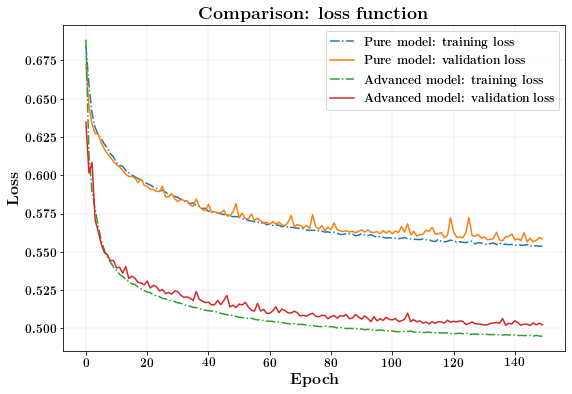

In [19]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

plt.plot(
    pure_dict['loss'],
    "-.",
    label = r"\bf{Pure model: training loss}"
)
plt.plot(
    pure_dict['val_loss'],
    label = r"\bf{Pure model: validation loss}"
)
plt.plot(
    opti_dict['loss'],
    "-.",
    label = r"\bf{Advanced model: training loss}"
)
plt.plot(
    opti_dict['val_loss'],
    label = r"\bf{Advanced model: validation loss}"
)

plt.xlabel(r"\bf{Epoch}")
plt.ylabel(r"\bf{Loss}")
plt.title(r"\bf{Comparison: loss function}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/comparison/results_comparison_loss.pdf", bbox_inches='tight')
plt.show()

### Accuracy plot

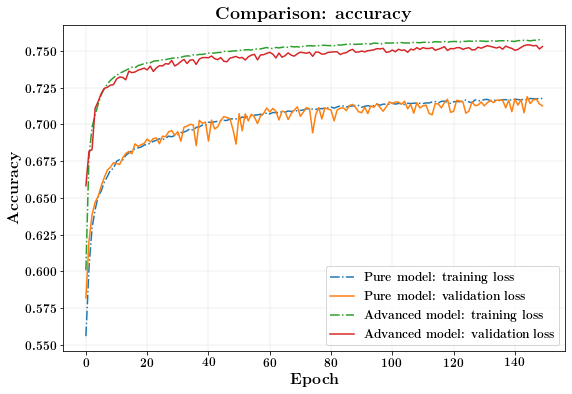

In [20]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

plt.plot(
    pure_dict['accuracy'],
    "-.",
    label = r"\bf{Pure model: training loss}"
)
plt.plot(
    pure_dict['val_accuracy'],
    label = r"\bf{Pure model: validation loss}"
)
plt.plot(
    opti_dict['accuracy'],
    "-.",
    label = r"\bf{Advanced model: training loss}"
)
plt.plot(
    opti_dict['val_accuracy'],
    label = r"\bf{Advanced model: validation loss}"
)

plt.xlabel(r"\bf{Epoch}")
plt.ylabel(r"\bf{Accuracy}")
plt.title(r"\bf{Comparison: accuracy}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/comparison/results_comparison_accuracy.pdf", bbox_inches='tight')
plt.show()

***

<br>
<br>
<br>
<br>
<br>

***

## Results: advanced TTN bond dimension characterisation

### Load data

In [21]:
with open(JSON_PATH + "characterization/bond_dim_behav.json", 'r') as jf:
    bond_dict = json.load(jf)
with open(JSON_PATH + "characterization/bond_dim_eval.json", 'r') as jf:
    bond_eval = json.load(jf)

In [22]:
bd   = []
los  = []
acc  = []
auc  = []
for k in bond_eval.keys():
    bd.append(int(k[3:]))
    los.append(bond_eval[k][0])
    acc.append(bond_eval[k][1])
    auc.append(bond_eval[k][2])
    
bd  = np.array(bd )    
los = np.array(los)
acc = np.array(acc)    
auc = np.array(auc)

sort = np.argsort(bd)
bd   = bd  [sort]
los  = los [sort]
acc  = acc [sort]
auc  = auc [sort]

### Loss plot

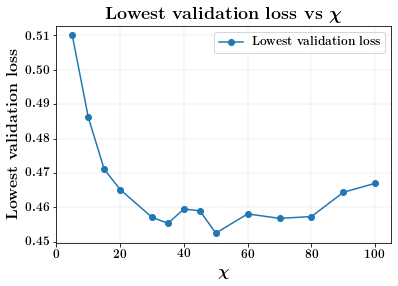

In [23]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    bd,
    los,
    "o-",
    label = r"\bf{Lowest validation loss}"
)

plt.xlim(0,105)
plt.title(r"\bf{Lowest validation loss vs $\chi$}")
plt.xlabel(r"\bf{$\chi$}")
plt.ylabel(r"\bf{Lowest validation loss}")
# plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'), weight='bold')

plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_bond_loss.pdf", bbox_inches='tight')
plt.show()

### Accuracy plot

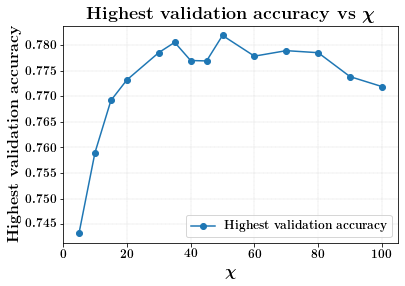

In [24]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    bd,
    acc,
    "o-",
    label = r"\bf{Highest validation accuracy}"
)

plt.xlim(0,105)
plt.title(r"\bf{Highest validation accuracy vs $\chi$}")
plt.xlabel(r"\bf{$\chi$}")
plt.ylabel(r"\bf{Highest validation accuracy}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_bond_accuracy.pdf", bbox_inches='tight')
plt.show()

### AUC plot

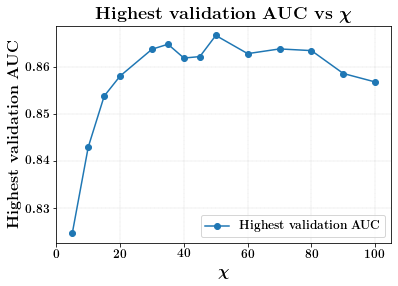

In [25]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    bd,
    auc,
    "o-",
    label = r"\bf{Highest validation AUC}"
)

plt.xlim(0,105)
plt.title(r"\bf{Highest validation AUC vs $\chi$}")
plt.xlabel(r"\bf{$\chi$}")
plt.ylabel(r"\bf{Highest validation AUC}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_bond_auc.pdf", bbox_inches='tight')
plt.show()

### Training time plot

In [26]:
bd    = []
tmean = []
tstd  = []
teval = []
tsig  = []
for k in bond_dict.keys():
    bd.append(int(k[2:]))
    tmean.append(bond_dict[k]['mean_train_time'])
    tstd .append(bond_dict[k]['std_train_time'])
    teval.append(bond_dict[k]['eval_time'])
    #teval.append(bond_eval_mean[k]['mean_eval_time'])
    #tsig.append(bond_eval_mean[k]['std_eval_time'])
    
bd    = np.array(bd )    
tmean = np.array(tmean)
tstd  = np.array(tstd )    
teval = np.array(teval)

sort  = np.argsort(bd)
bd    = bd  [sort]
tmean = tmean [sort]
tstd  = tstd  [sort]
teval = teval [sort]

In [27]:
from scipy.optimize import curve_fit

def func(x, a, b ,c):
    return a*x**b +c

popt, pcov = curve_fit(func, bd, tmean)

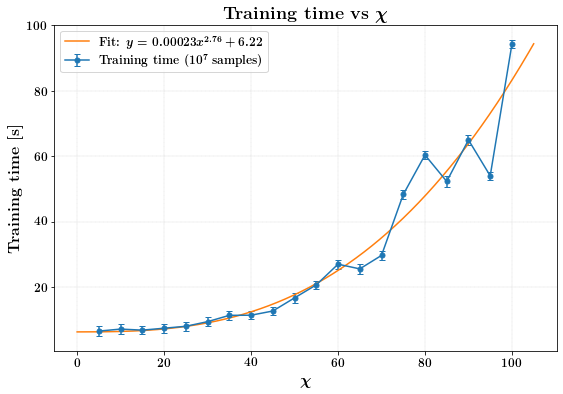

In [28]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

x = np.linspace(0, 105, 1050)
plt.errorbar(
    bd,
    tmean,
    tstd,
    fmt        ='o-',
    markersize = 5,
    capsize    = 3,
    label      = r"\bf{Training time ($10^{7}$ samples)}"
)
plt.plot(
    x,
    func(x, *popt),
    label = r"\bf{Fit: $y={%1.5f}x^{%1.2f} +{%1.2f}$}" % (np.round(popt[0],5), np.round(popt[1],2), np.round(popt[2],2)),
)

# plt.xlim(1,105)
plt.title(r"\bf{Training time vs $\chi$}")
plt.xlabel(r"\bf{$\chi$}")
plt.ylabel(r"\bf{Training time [s]}")
# plt.xscale("log")
# plt.yscale("log")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_bond_training.pdf", bbox_inches='tight')
plt.show()

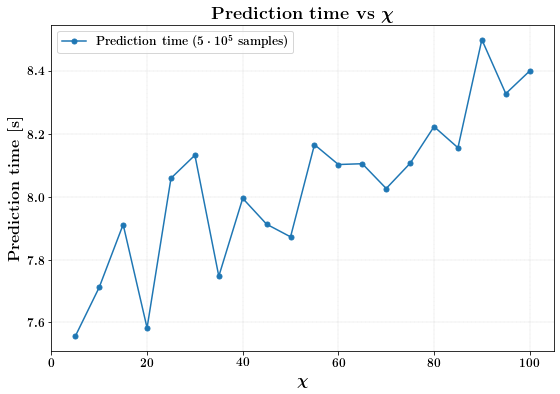

In [29]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

x = np.linspace(0, 105, 1050)
plt.plot(
    bd,
    teval,
    'o-',
    markersize = 5,
    label      = r"\bf{Prediction time ($5 \cdot 10^{5}$ samples)}"
)

plt.xlim(0,105)
plt.title(r"\bf{Prediction time vs $\chi$}")
plt.xlabel(r"\bf{$\chi$}")
plt.ylabel(r"\bf{Prediction time [s]}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_bond_prediction.pdf", bbox_inches='tight')
plt.show()

***

<br>
<br>
<br>
<br>
<br>

***

## Results: advanced TTN batch size characterisation

### Load data

In [30]:
with open(JSON_PATH + "characterization/batch_size_times.json", 'r') as jf:
    batch_dict = json.load(jf)

In [31]:
bs      = []
t_mean  = []
t_std   = []

for k in batch_dict.keys():
    bs.append(int(k[3:]))
    t_mean.append(batch_dict[k]["mean_train_time"])
    t_std .append(batch_dict[k]["std_train_time"])
    
bs    = np.array(bs )    
t_mean = np.array(t_mean)
t_std  = np.array(t_std )    

sort  = np.argsort(bs)
bs    = bs  [sort]
t_mean = t_mean[sort]
t_std  = t_std [sort]

### Batch size plot

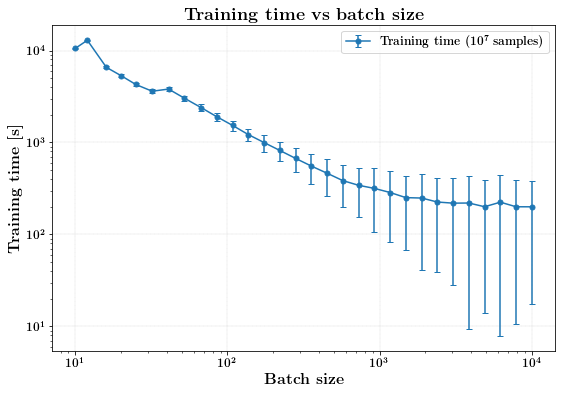

In [32]:
plt.figure(figsize=(9,6))
plt.axes(axisbelow=True)

x = np.linspace(0, 105, 1050)
plt.errorbar(
    bs,
    t_mean * 200 / t_mean[-1],
    t_std * 200 / t_mean[-1],
    fmt        ='o-',
    markersize = 5,
    capsize    = 3,
    label      = r"\bf{Training time ($10^{7}$ samples)}"
)
# plt.plot(
#     x,
#     func(x, *popt),
#     label = r"\bf{Fit: $y={%1.5f}x^{%1.2f} +{%1.2f}$}" % (np.round(popt[0],5), np.round(popt[1],2), np.round(popt[2],2)),
# )

# plt.xlim(1,105)
plt.title(r"\bf{Training time vs batch size}")
plt.xlabel(r"\bf{Batch size}")
plt.ylabel(r"\bf{Training time [s]}")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/characterisation/results_characterisation_batch.pdf", bbox_inches='tight')
plt.show()

***

<br>
<br>
<br>
<br>
<br>

***

## Results: final TTN run

### Load data

In [33]:
#load model history
with open(JSON_PATH + "/../json/history/20210301-085018__etr_10000000__nc_2__map_spherical_5__bd_50__bs_10000__ep_500__opt_adam__act_elu__history.json") as jf:
    history = json.load(jf)

### Loss plot

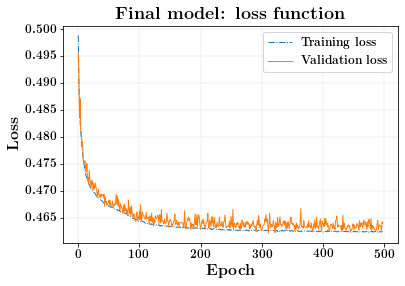

In [34]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    history['loss'][1:],
    '-.',
    label = r"\bf{Training loss}",
    linewidth = 1
)
plt.plot(
    history['val_loss'][1:],
    '-',
    label = r"\bf{Validation loss}",
    linewidth = 1
)

plt.xlabel(r"\bf{Epoch}")
plt.ylabel(r"\bf{Loss}")
plt.title(r"\bf{Final model: loss function}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/final/results_final_loss.pdf", bbox_inches='tight')
plt.show()

### Accuracy plot

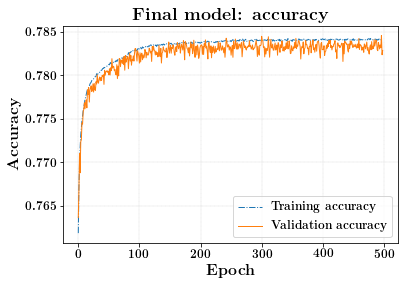

In [35]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    history['accuracy'][1:],
    '-.',
    label     = r"\bf{Training accuracy}",
    linewidth = 1
)
plt.plot(
    history['val_accuracy'][1:],
    '-',
    label     = r"\bf{Validation accuracy}",
    linewidth = 1
)

plt.xlabel(r"\bf{Epoch}")
plt.ylabel(r"\bf{Accuracy}")
plt.title(r"\bf{Final model: accuracy}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/final/results_final_accuracy.pdf", bbox_inches='tight')
plt.show()

### AUC plot

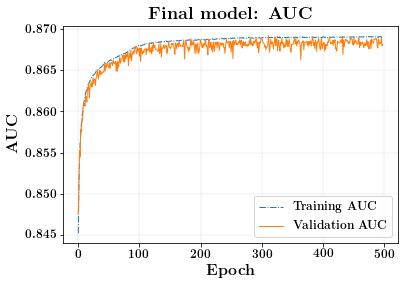

In [36]:
plt.figure(figsize=(6,4))
plt.axes(axisbelow=True)

plt.plot(
    history['auc'][1:],
    '-.',
    label     = r"\bf{Training AUC}",
    linewidth = 1
)
plt.plot(
    history['val_auc'][1:],
    '-',
    label     = r"\bf{Validation AUC}",
    linewidth = 1
)

plt.xlabel(r"\bf{Epoch}")
plt.ylabel(r"\bf{AUC}")
plt.title(r"\bf{Final model: AUC}")
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.25)

plt.savefig(SAVE_PATH + "results/final/results_final_auc.pdf", bbox_inches='tight')
plt.show()